In [29]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time
import astropy.units as u
from astropy.visualization import time_support
from astropy.table import Table

import photutils
from photutils.aperture import ApertureStats

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, moments, seeing, analyze_dimm_cube

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x15f64edd0>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [13]:
qe_tab = Table.read("~/MMT/timdimm_tng/notebooks/asi432mm_qe.csv", format="ascii.csv", names=["wavelength", "qe"])
np.sum(qe_tab["qe"] * qe_tab["wavelength"]) /np.sum(qe_tab["qe"])

639.375040081782

In [16]:
206265 * 9e-6 / 2.5

0.7425539999999999

In [17]:
plt.close('all')

In [43]:
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-21-31.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-18-32.ser"
d = load_ser_file(testfile)

/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [44]:
d.keys()

dict_keys(['filename', 'file_id', 'lu_id', 'color_id', 'nplanes', 'littleendian', 'im_width', 'im_height', 'pix_depth_per_plane', 'bytes_per_pixel', 'nframe', 'observer', 'instrument', 'telescope', 'dateobs', 'dateobs_utc', 'data', 'frame_times'])

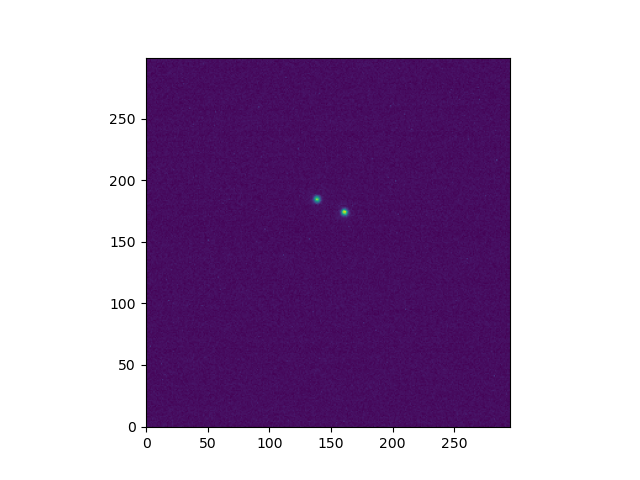

In [45]:
fig, ax = plt.subplots()
ax.imshow(d["data"][100], origin="lower")
plt.show()

In [46]:
aps = find_apertures(d['data'][2000])
ap_stats = ApertureStats(d['data'][2000], aps[0])
ap_stats.centroid

array([[137.5021171 , 194.29872974],
       [160.9780894 , 182.371896  ]])

In [47]:
ave_seeing, seeing_vals, baselines, apertures, frame_times, nbad, fig = analyze_dimm_cube(testfile, plot=False)
ave_seeing

/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<Quantity 1.32104438 arcsec>

In [39]:
nbad

4995

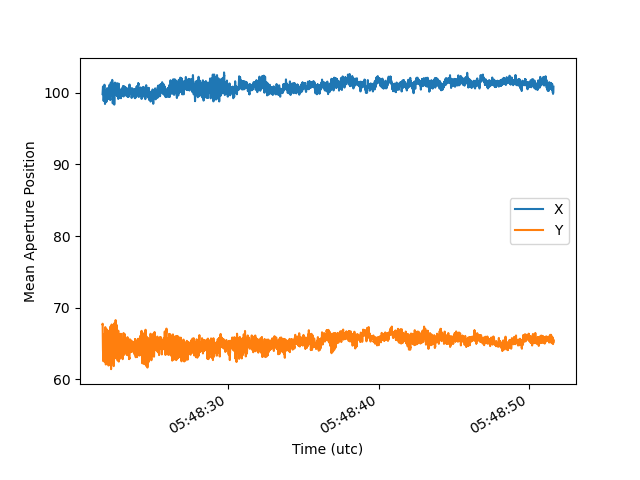

In [20]:
fig, ax = plt.subplots()
ax.plot(frame_times, apertures[0], label='X')
ax.plot(frame_times, apertures[1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

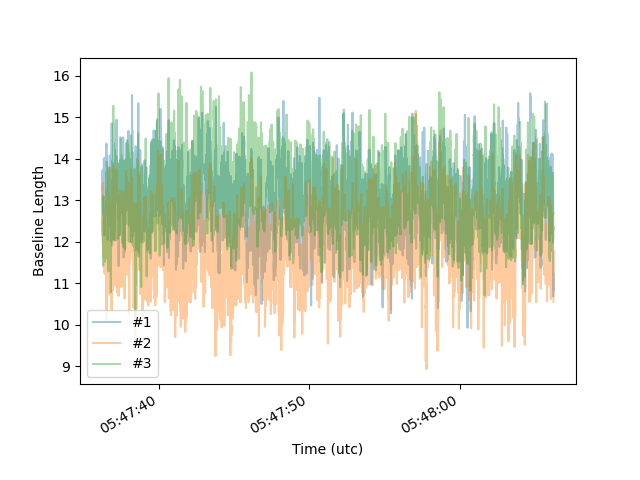

In [14]:
fig, ax = plt.subplots()
ax.plot(frame_times, baselines[0], label='#1', alpha=0.4)
ax.plot(frame_times, baselines[1], label='#2', alpha=0.4)
ax.plot(frame_times, baselines[2], label='#3', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

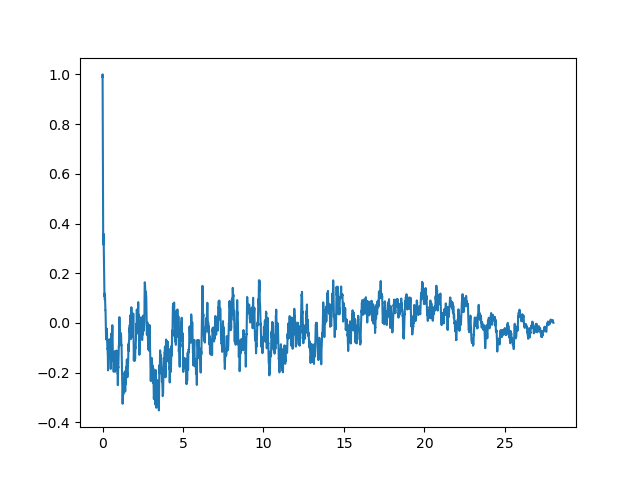

In [18]:
b0 = baselines[0] - baselines[0].mean()
b1 = baselines[1] - baselines[1].mean()
b2 = baselines[2] - baselines[2].mean()
dt = (frame_times[1] - frame_times[0]).to_value('sec')
autocor = np.correlate(b0, b2, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()